In [34]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, recall_score, balanced_accuracy_score, roc_curve
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

# Reading, Preprocessing and EDA

In [36]:
Train_path = "../datasets/adult/adult.csv"
train_df = pd.read_csv(Train_path, header = 0)
print("done")

done


In [37]:
print(train_df.isnull().sum().sum(), train_df.isna().sum().sum())

0 0


In [38]:
list_dtype = [train_df[i].dtype for i in train_df.columns]
print(dict((i, list_dtype.count(i)) for i in list_dtype))

{dtype('int64'): 6, dtype('O'): 9}


In [39]:
train_df = train_df.replace('?', np.NaN)

In [40]:
num_col = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [41]:
list_dtype = [train_df[i].dtype for i in train_df.columns]
print(dict((i, list_dtype.count(i)) for i in list_dtype))

{dtype('int64'): 6, dtype('O'): 9}


In [42]:
for col in num_col:
    train_df[col] = pd.to_numeric(train_df[col], errors="coerce") 

In [43]:
list_dtype = [train_df[i].dtype for i in train_df.columns]
print(dict((i, list_dtype.count(i)) for i in list_dtype))

{dtype('int64'): 6, dtype('O'): 9}


In [44]:
for col in train_df.columns:
    if 'int' in train_df[col] or 'float' in train_df[col]:
        train_df[col] = train_df[col].fillna(train_df[col].mean())
    else:
        mode_val = train_df[col].mode()[0]
        train_df[col] = train_df[col].fillna(mode_val)

In [45]:
print(train_df.isna().sum().sum())

0


In [46]:
print(train_df['income'].value_counts())

<=50K    37155
>50K     11687
Name: income, dtype: int64


In [47]:
label_encoder = LabelEncoder()
i = 'income'
train_df[i] = label_encoder.fit_transform(train_df[i])    

In [48]:
train_df = pd.get_dummies(train_df)

In [49]:
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
scl.fit(train_df)
scl.transform(train_df)
train_df, test_df = train_test_split(train_df, train_size = 0.9, random_state = 42) 
y_train = train_df['income']
y_test = test_df['income']
X_train = train_df.drop(['income'], axis = 1)
X_test = test_df.drop(['income'], axis = 1)

In [50]:
class CentroidSMOTE():
    def __init__(self, sampling_strategy='auto', random_state=42, k_neighbors=5, m_vertices=3):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.k_neighbors = k_neighbors
        self.m_vertices = m_vertices
    
    @staticmethod
    def nearest_neighbor(X, k):
        from sklearn.neighbors import NearestNeighbors
        nbs=NearestNeighbors(n_neighbors=k+1,metric='euclidean',algorithm='kd_tree').fit(X)
        euclidean,indices= nbs.kneighbors(X)
        return indices[:, 1:]
    
    def fit_resample(self, X, y):
        
        (unique, freq) = np.unique(y, return_counts=True)
        frequency = dict(zip(unique, freq))
        max_frequency = max(frequency.values())
        
        if self.sampling_strategy == 'auto':
            sampling_strategy = {}
            for (key, value) in frequency.items():
                sampling_strategy[key] = max_frequency - value
            self.sampling_strategy = sampling_strategy
            
        data = {}
        for (key, value) in self.sampling_strategy.items():
            if value == 0:
                continue
            X_small = X[y == key]
            indices = self.nearest_neighbor(X_small, self.k_neighbors)
            new_data = []
            for idx in np.random.choice(np.arange(len(X_small)), size=value):
                p = X_small[idx]
                nnarray = indices[idx]
                q = X_small[np.random.choice(nnarray, size=self.m_vertices-1, replace=False)]
                new_data.append(np.sum(np.vstack([p, q]), axis=0)/self.m_vertices)
            X_new = np.vstack(new_data)
            data[key] = X_new
        
        for (key, value) in data.items():
            X = np.vstack([X, value])
            y = np.concatenate([y, np.ones(len(value))*key])
        
        X, y = shuffle(X, y, random_state=self.random_state)
        
        return X, y        

In [51]:
def score(X_test, y_test, model):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy: {acc:.6f}")
    print(f"Error Rate: {1-acc}")
    Recall = recall_score(y_test, y_pred, average='macro')      
    print(f"Mean Recall: {Recall}")
    print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")
    Array_prec_recall_f = precision_recall_fscore_support(y_test, y_pred, average='macro')
#                                                                         average = 'micro', 'macro', 'weighted'
    print(f"Precision: {Array_prec_recall_f[0]}")
    print(f"F-Score: {Array_prec_recall_f[2]}")
          
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    print(len(y_pred), len(y_test))
    for i in range(len(y_pred)): 
        if y_test[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_test[i]!=y_pred[i]:
           FP += 1
        if y_test[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_test[i]!=y_pred[i]:
           FN += 1
    if TN + FP == 0: 
      Selectivity = 0
    else:
      Selectivity = TN/(TN + FP)
    G_mean = np.sqrt(Selectivity*Recall) 
    print(f"Selectivity: {Selectivity}") 
    print(f"G_mean: {G_mean}")   
    
    
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot()
    plt.show()
    
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
   
        

In [52]:
pipeline = Pipeline([
    ('classifier', KNeighborsClassifier(metric='euclidean'))
])

parameters = {
    'classifier__n_neighbors' : [3, 5, 7, 9, 11],
}

In [53]:
y_test = y_test.to_numpy()
y_train = y_train.to_numpy()
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.798158
Error Rate: 0.20184237461617194
Mean Recall: 0.621101696005824
Balanced Accuracy Score: 0.621101696005824
Precision: 0.7530036928643031
F-Score: 0.6394521984342709
4885 4885
Selectivity: 0.96148666846216
G_mean: 0.7727748704951767


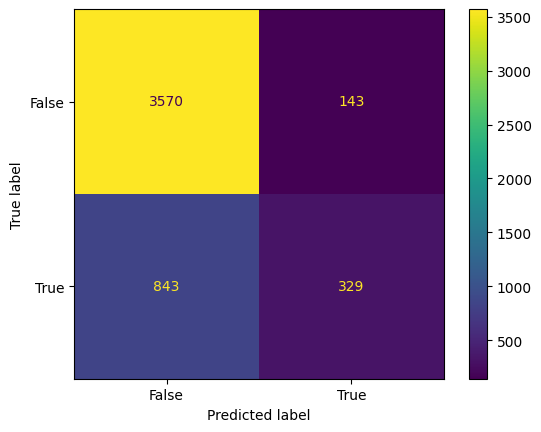

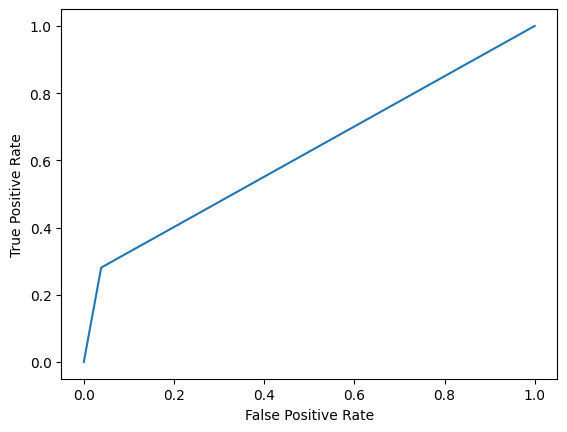

In [54]:
clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train, y_train)
score(X_test, y_test, best_clf)

Resampled dataset shape Counter({0: 33442, 1: 33442})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.685568
Error Rate: 0.31443193449334694
Mean Recall: 0.6471795894693397
Balanced Accuracy Score: 0.6471795894693397
Precision: 0.618030722869807
F-Score: 0.6218674407353653
4885 4885
Selectivity: 0.7209803393482359
G_mean: 0.6830840065722931


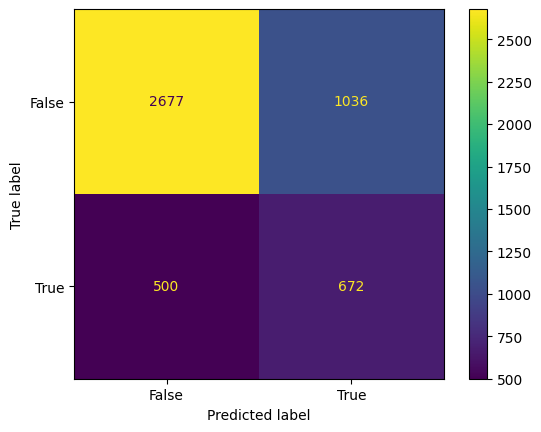

Resampled dataset shape Counter({0: 33442, 1: 33442})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.677994
Error Rate: 0.3220061412487206
Mean Recall: 0.6465764829595122
Balanced Accuracy Score: 0.6465764829595122
Precision: 0.6155468502332322
F-Score: 0.6178465509754851
4885 4885
Selectivity: 0.7069754915162941
G_mean: 0.6761018612924963


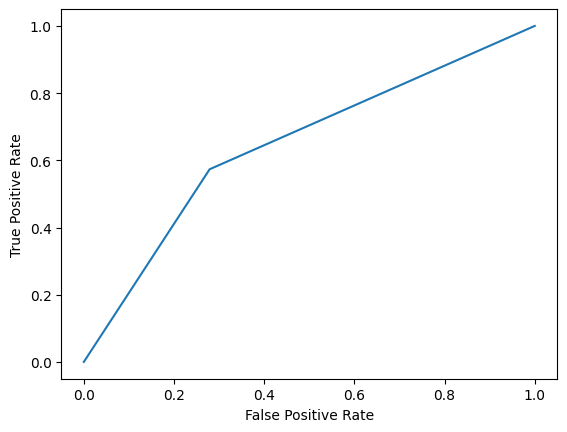

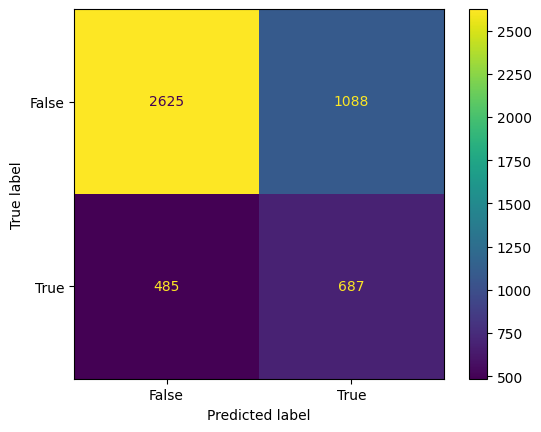

Resampled dataset shape Counter({0: 33442, 1: 33442})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.673695
Error Rate: 0.32630501535312184
Mean Recall: 0.6431646626693961
Balanced Accuracy Score: 0.6431646626693961
Precision: 0.6124010763070991
F-Score: 0.6140040561178257
4885 4885
Selectivity: 0.7018583355776999
G_mean: 0.6718708801872092


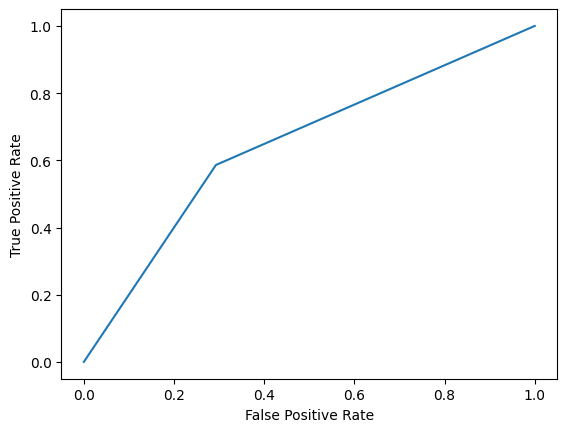

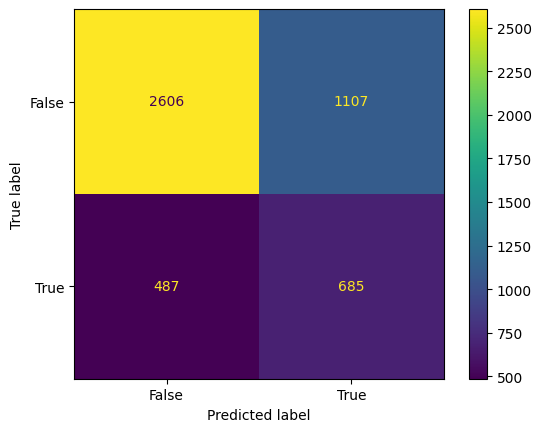

Resampled dataset shape Counter({0: 33442, 1: 33442})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.669396
Error Rate: 0.33060388945752306
Mean Recall: 0.6385850057311779
Balanced Accuracy Score: 0.6385850057311779
Precision: 0.608577721268844
F-Score: 0.6095864199996031
4885 4885
Selectivity: 0.6978184756261783
G_mean: 0.6675450660869758


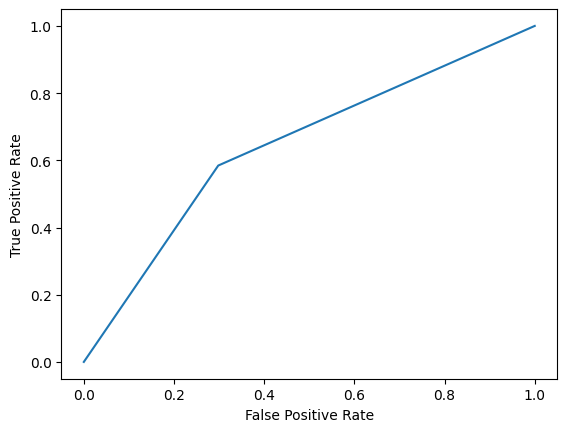

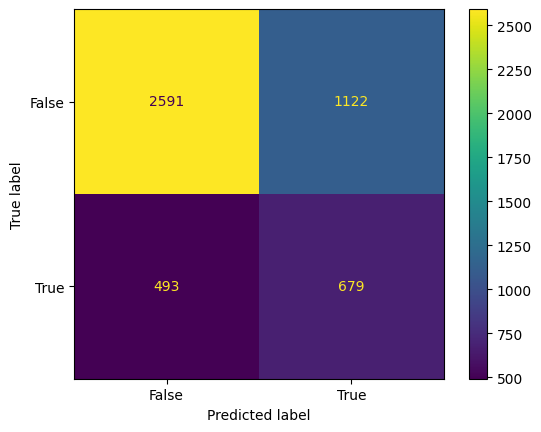

Resampled dataset shape Counter({0: 33442, 1: 33442})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.657728
Error Rate: 0.3422722620266121
Mean Recall: 0.6317851493093631
Balanced Accuracy Score: 0.6317851493093631
Precision: 0.6018409403133715
F-Score: 0.6004915570132962
4885 4885
Selectivity: 0.6816590358200916
G_mean: 0.6562484710257793


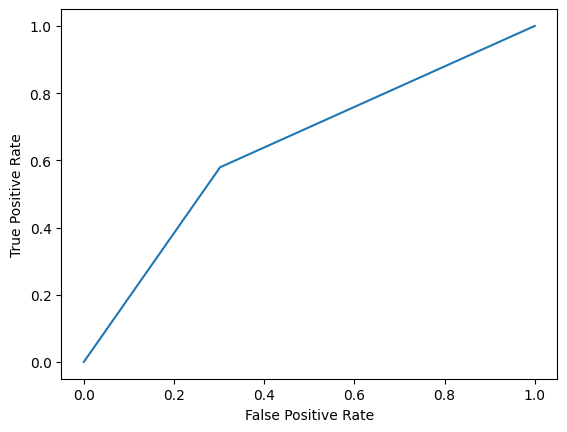

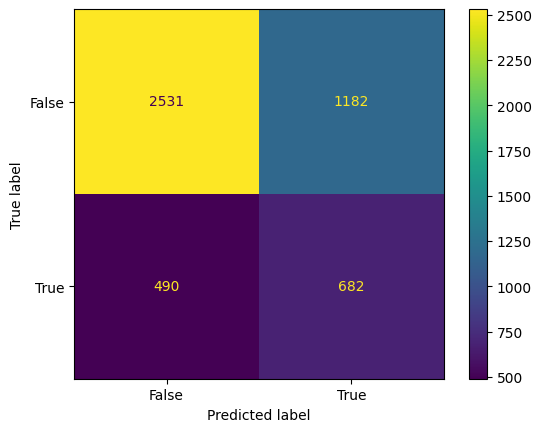

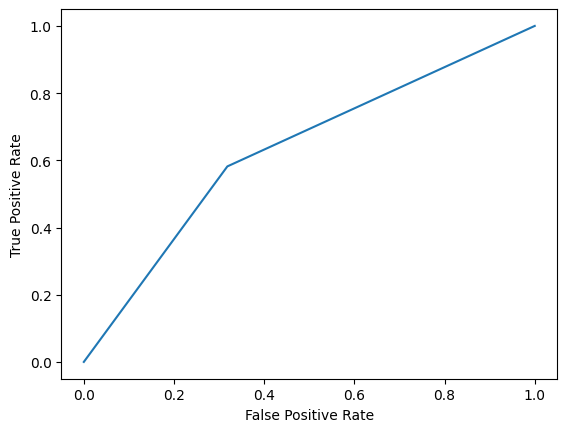

In [55]:
sm_list = []
from collections import Counter
for i in [3, 5, 7, 9, 11]:
    sm_list.append(SMOTE(random_state=42, k_neighbors=i))
for sm in sm_list:
    X_new, y_new = sm.fit_resample(X_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_new))
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.681883
Error Rate: 0.3181166837256909
Mean Recall: 0.6444637143364014
Balanced Accuracy Score: 0.6444637143364014
Precision: 0.6153584947346247
F-Score: 0.6186642718097017
4885 4885
Selectivity: 0.716401831403178
G_mean: 0.6794814090344875


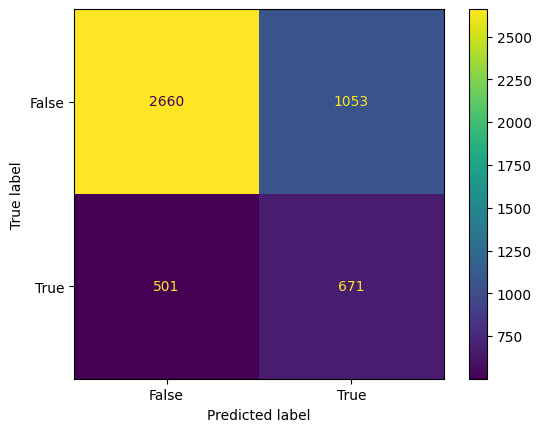

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.672671
Error Rate: 0.3273285568065507
Mean Recall: 0.6407395977053227
Balanced Accuracy Score: 0.6407395977053227
Precision: 0.6106799493991144
F-Score: 0.6122754341659485
4885 4885
Selectivity: 0.7021276595744681
G_mean: 0.6707316856489818


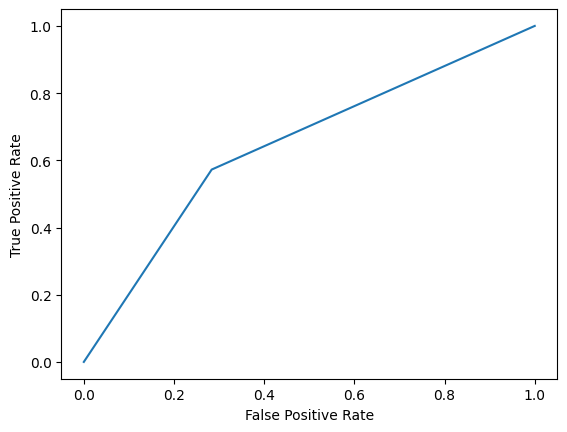

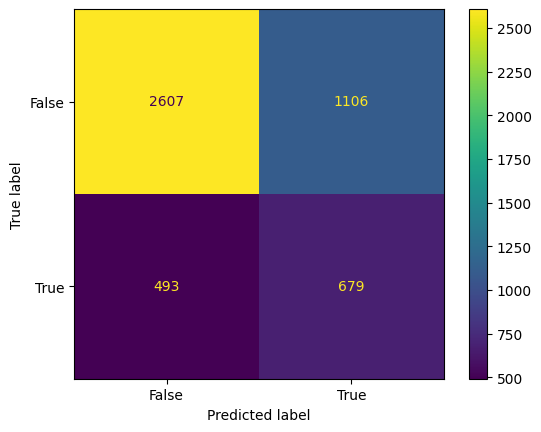

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.675742
Error Rate: 0.3242579324462641
Mean Recall: 0.6491826292456446
Balanced Accuracy Score: 0.6491826292456446
Precision: 0.616534285776857
F-Score: 0.6180169406917817
4885 4885
Selectivity: 0.7002423915970913
G_mean: 0.6742293355277995


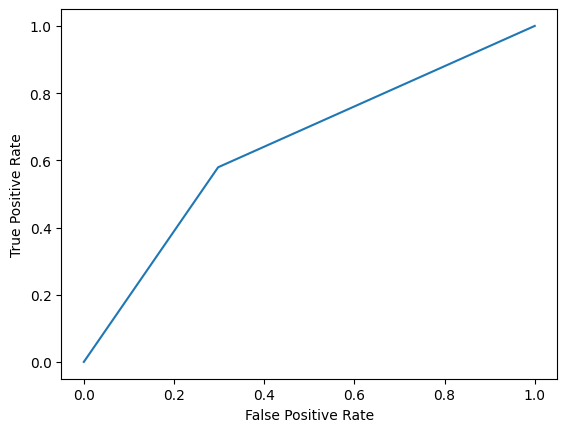

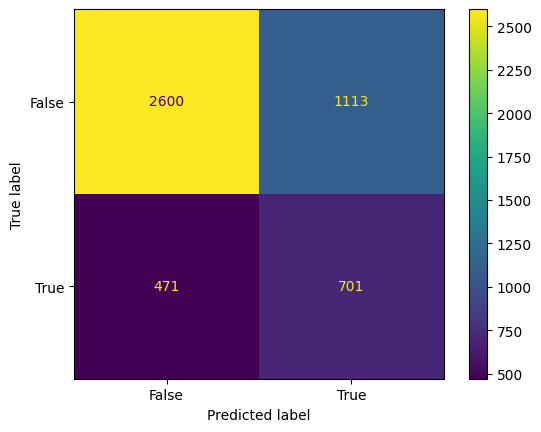

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.683930
Error Rate: 0.3160696008188332
Mean Recall: 0.6472701301303694
Balanced Accuracy Score: 0.6472701301303694
Precision: 0.6175994997030955
F-Score: 0.6211181696745042
4885 4885
Selectivity: 0.7177484513870186
G_mean: 0.6815989535864522


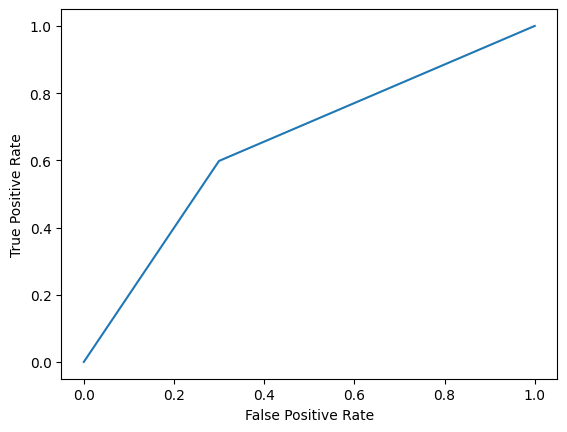

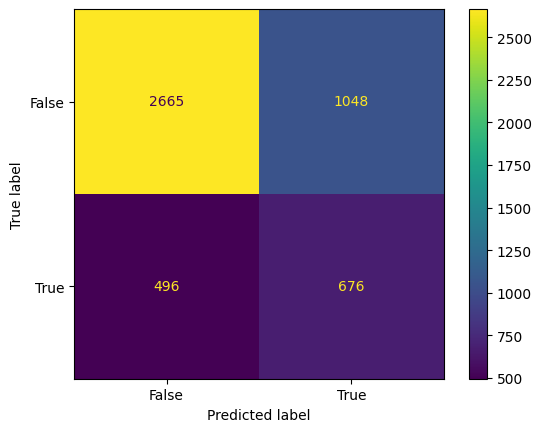

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.679427
Error Rate: 0.32057318321392014
Mean Recall: 0.6445995253279456
Balanced Accuracy Score: 0.6445995253279456
Precision: 0.6147528501993991
F-Score: 0.6175427457254274
4885 4885
Selectivity: 0.711553999461352
G_mean: 0.6772498581011211


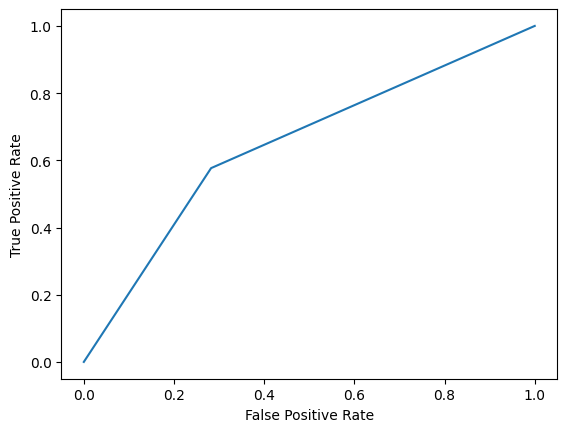

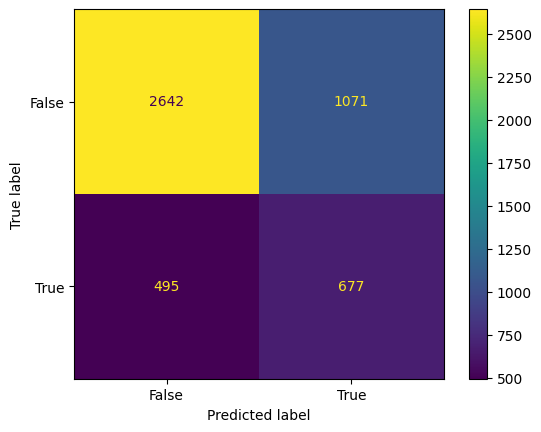

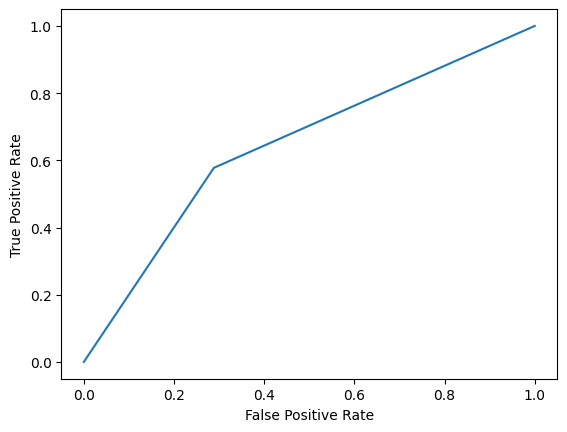

In [56]:
csm_list = []
for (i,j) in [(5,3), (7,3), (9,3), (7,5), (9,7)]:
    csm_list.append(CentroidSMOTE(k_neighbors=i, m_vertices=j))

for csm in csm_list:
    X_new, y_new = csm.fit_resample(X_train, y_train)
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)